In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.metrics import pairwise_distances
from scanpy import read_h5ad
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

#distribution of distances between 2 types instead of just observation frequency
cell_h5ad = read_h5ad('/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/resegmented_data_copies/all_reseg_with_layers_011023_annotated_with_depth.h5ad')
#obs has class, obsm spatial has location. IDs are matched (so spatial 0 = obs 0)
cell_data = cell_h5ad.obs[cell_h5ad.obs['selected_cells']==True]

In [7]:
import sys
#iterate over pairs, then over circle point multipliers to get all possible pairwise distance groupings
#save to a separate file each time
def pairwise_dist_iters(input_df):
    obs_freqs = []
    for class_pair in unique_subset_pairs:
        #for each pair of subclasses in all possible pairs of subclasses, skip if we've seen it before (i.e., don't run x vs y if we've run y vs x).
        #additionally, itertools.combinations doesn't return x vs x or y vs y so add those to the potential iteration options if they haven't been done before.
        pair_iters = [[class_pair[0], class_pair[1]]]
        if class_pair[0] not in obs_freqs:
            pair_iters.append([class_pair[0], class_pair[0]])
            obs_freqs.append(class_pair[0])
        if class_pair[1] not in obs_freqs:
            pair_iters.append([class_pair[1], class_pair[1]])
            obs_freqs.append(class_pair[1])
        for group in pair_iters:
            print(group)
            #create blank df for holding the one calculation of true distances and 10 calculations of randomly shifted distances
            temp_df = pd.DataFrame()
            group_name = str(group[0])+','+str(group[1])
            for i in range(0,11): #11
                if i == 0:
                    pair_0 = input_df[input_df['subclass_scANVI']==group[0]][['napari_x', 'napari_y']].values.copy()
                    pair_1 = input_df[input_df['subclass_scANVI']==group[1]][['napari_x', 'napari_y']].values.copy() 
                    index = '_realdata'
                else:
                    # uniformly random values within 50um circle
                    n = max(len(input_df[input_df['subclass_scANVI']==group[0]]), len(input_df[input_df['subclass_scANVI']==group[1]]))
                    radius = np.random.uniform(low=0, high=50, size=n*5)  # varies within 50
                    theta = np.random.uniform(low=0, high=2*np.pi, size=n*5)  # angle
                    rand_circle_points = pd.DataFrame({'x': np.sqrt(radius) * np.cos(theta), 'y':np.sqrt(radius) * np.sin(theta)}) #circle
                    rand_subset_0 = rand_circle_points.sample(len(input_df[input_df['subclass_scANVI']==group[0]])).values.copy()
                    rand_subset_1 = rand_circle_points.sample(len(input_df[input_df['subclass_scANVI']==group[1]])).values.copy()
                    pair_0 = input_df[input_df['subclass_scANVI']==group[0]][['napari_x', 'napari_y']].values.copy()+rand_subset_0
                    pair_1 = input_df[input_df['subclass_scANVI']==group[1]][['napari_x', 'napari_y']].values.copy()+rand_subset_1
                    index = '_iter'+str(i)
                clust_dists_pair = np.tril(pairwise_distances(pair_0, pair_1, n_jobs=1)) 
                clust_dists_pair[clust_dists_pair==0] = np.nan
                pair_col = group_name+index
                pair_df = pd.DataFrame(pd.Series(clust_dists_pair.flatten()[:]), columns = [pair_col])
                temp_df = pd.concat([temp_df, pair_df], axis=1) 
            if '/' in group_name:
                group_name = group_name.replace('/', '')
            csv_name = str(root_folder.joinpath(barcode))+'/'+barcode+'_'+group_name+'_10423.csv'
            temp_df.to_csv(csv_name, index=False)

In [18]:
def calc_z_score(new_root, bc):
    cci_csvs = new_root.glob('*.csv')
    obs_freqs = pd.DataFrame(columns=['pair_0', 'pair_1', 'z_score'])
    for cci in list(cci_csvs):
        # calculate one-tailed z-test of observed vs randomized for every group
        group_df = pd.read_csv(cci)
        slim_df = group_df[group_df.transform(lambda x: x <= 15)].dropna(how='all')
        sample_colname = [x for x in list(slim_df.columns) if '_realdata' in x][0]
        sample = slim_df.loc[:, slim_df.columns == sample_colname].count()
        population = slim_df.loc[:, slim_df.columns != sample_colname].count()
        # z = (sample mean – population mean) / [population standard deviation/sqrt(n)]
        z = (sample - np.mean(population)) / (np.std(population)/np.sqrt(10)) 
        comp_vals = sample_colname.split(',')
        obs_freqs.loc[len(obs_freqs), obs_freqs.columns] = comp_vals[0], comp_vals[1].split('_')[0], z.values[0]
        if abs(z.values[0]) >= 0.5:
            split_name = cci.stem.split('_')
            bc = split_name[0]
            comp_classes = split_name[1]
            z_df = group_df[group_df.transform(lambda x: x <= 100)].dropna(how='all')
            plt.figure()
            real_hist = plt.hist(z_df.loc[:, z_df.columns == sample_colname], color = 'y', alpha=0.5, bins = 10, range = (0, 110), label = 'real data')
            try:
                shuf_hist = plt.hist(z_df.loc[:, z_df.columns != sample_colname].iloc[:, 1], alpha=0.5, bins = 10, range = (0, 110), label = 'shuffled data')
            except ValueError:
                continue
            plt.xlabel(sample_colname.split('_')[0])
            plt.ylabel('counts')
            plt.title(comp_classes + ' '+ bc)
            plt.text(80, 2, 'z score: '+str(round(z.values[0], 3)))
            plt.legend()
            #print(str(new_root.joinpath(bc+'_'+comp_classes+'_100um_hist.png')))
            #plt.savefig(str(new_root.joinpath(bc+'_'+comp_classes+'_100um_hist.png')))
    return obs_freqs

In [23]:
def cci_bubble_plot(unique_classes, obs_freqs, savepath, bc):
    #put everything together - pairs and inverses, coordinates for plotting, and proximity values for adjusting size/color of plotted point
    for i in range(len(unique_classes)):
        for j in range(len(unique_classes)):
            idx = obs_freqs.index[(obs_freqs['pair_0']==unique_classes[i])&(obs_freqs['pair_1']==unique_classes[j])]
            obs_freqs.loc[idx, 'x'] = i
            obs_freqs.loc[idx, 'y'] = j

    #create scatterplot of the above matrix that matches the Zhuang 3B plot
    class_to_color = {'exc': 'red', 'inh': 'blue', 'glia': 'k'}
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.scatter(obs_freqs['x'], obs_freqs['y'], s=obs_freqs['z_score'].tolist(), c = obs_freqs['z_score'].tolist(), vmin = -50, vmax=50)
    plt.scatter(obs_freqs['y'], obs_freqs['x'], s=obs_freqs['z_score'].tolist(), c = obs_freqs['z_score'].tolist(), vmin = -50, vmax=50)


    plt.xticks(range(len(unique_classes)), unique_classes, size='small', rotation=70)
    for xtic in ax.get_xticklabels():
        xtic.set_color(class_to_color[subclass_to_class[xtic.get_text()]])

    plt.yticks(range(len(unique_classes)), unique_classes, size='small')
    for ytic in ax.get_yticklabels():
        ytic.set_color(class_to_color[subclass_to_class[ytic.get_text()]])

    plt.title(bc+' abs(z)>=0.5')
    plt.colorbar()
    #plt.savefig(savepath)

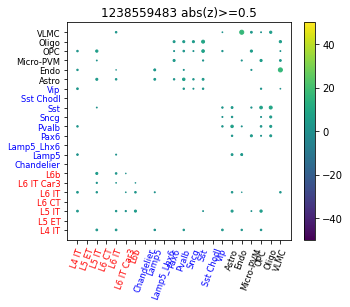

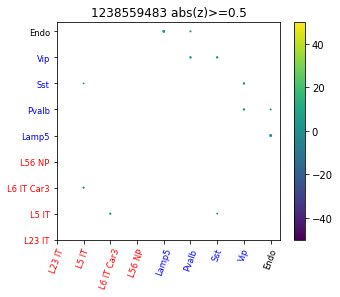

In [27]:
#for barcode in cell_data['filename'].unique().tolist():
barcode = '1238559483'
subset_data= cell_data[cell_data['filename']==barcode].copy() 
subclasses = list(subset_data.groupby('subclass_scANVI').groups.keys())
unique_subset_pairs = list(itertools.combinations(subclasses, 2))
root_folder = Path('/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/')
root_folder.joinpath(barcode).mkdir(parents=True, exist_ok=True)
#pairwise_dist_iters(subset_data)
#new_root = root_folder.joinpath(barcode)
#obs_freqs = calc_z_score(new_root, barcode)
#display(obs_freqs)

#grab set of all subclasses in list of significant pairs
flat_split = obs_freqs['pair_1'].unique().tolist() + obs_freqs['pair_0'].unique().tolist()
u_subc = list(subset_data['subclass_scANVI'].unique())
classes = [subset_data[subset_data['subclass_scANVI']==sub]['class'].values[0] for sub in u_subc]
u_subc_noslash=[x.replace('/', '') for x in u_subc]
subclass_to_class = dict(zip(u_subc_noslash, classes)) 

#organize to match Zhuang figure
exc_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='exc' and sub in flat_split])
inh_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='inh' and sub in flat_split])
glia_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='glia' and sub in flat_split])
unique_classes = exc_subc+inh_subc+glia_subc
cci_bubble_plot(unique_classes, obs_freqs.copy(), new_root.joinpath(barcode+'_3b_fullplot.png'), barcode)

zhuang_subs = ['L23 IT', 'L5 IT', 'L6 IT Car3','L56 NP','Lamp5', 'Pvalb', 'Sst', 'Vip', 'Endo']
cci_bubble_plot(zhuang_subs, obs_freqs.copy(), new_root.joinpath(barcode+'_3b_zmatch.png'), barcode)

### test/scratch below

In [ ]:
#do a hist of each column and plot. Can use that output to make sure that this is normal and not all nans
# for x in container_df.columns:
#     plt.figure()
#     plt.hist([container_df.loc[:,x]], bins = 100)
#     lab_split = x.split(',')
#     plt.xlabel(str(x))
#     plt.ylabel('pairwise dist vals')
    
#random scatter plotting stuff
#plt.scatter(proximity_df['x'], proximity_df['y'], s = proximity_df['num_proximal']*10, c = proximity_df['color'])
#fig, ax = plt.subplots()
#proximity_df.plot('x', 'y', kind= 'scatter', c='num_proximal', s = 'num_proximal', colormap = 'spring', ax=ax, label=index)
# for i, point in proximity_df.iterrows():
#     ax.text(point['x'], point['y']-.5, str(i))


# proximity_df = pd.DataFrame(columns = ['comp_class', 'num_proximal', 'x', 'y','color', 'barcode'])
# proximity_df['comp_class'] = test.keys()
# proximity_df['num_proximal'] = proximity_df['comp_class'].map(test)
# proximity_df = proximity_df.set_index('comp_class')
# proximity_df['barcode'] = bc
# coords = []
# for i in range(7):
#     for j in range(7):
#         coords.append([i, j])
# proximity_df[['x', 'y']] = coords

# colors = list(mcolors.XKCD_COLORS)[:49]
# proximity_df['color'] = colors

# for idx, row in proximity_df.iterrows():
#     plt.scatter(row['x'], row['y'], s=row['num_proximal']*5, c= row['color'], label = idx)
# plt.legend(bbox_to_anchor=(1.1, 1.05))
#ok great. Now split each half of the pair is on x/y axes and plot again
# split_classes = [x.split(',') for x in test.keys()]

# x_classes = [x+'_x' for x in unique_classes]
# y_classes = [x+'_y' for x in unique_classes]
# prox_df = pd.DataFrame(columns = unique_classes, index = unique_classes)
# for i in unique_classes:
#     for j in unique_classes:
#         combo = str(i)+','+str(j)
#         res = 0
#         if combo in test.keys():
#             prox_df.loc[j, i] = test[combo]
#             prox_df.loc[i, j] = test[combo]

cell-cell interactions arising from somatic contact or paracrine signaling, which can be inferred based on contact or proximity between cells that occurred with higher frequency than by random chance (29, 30). 

We examined whether these potential cell-cell interactions were cell-type specific. To this end, we only considered cell types at the subclass level and determined the frequency with which cell-cell contacts (or proximity) were observed between two subclasses of cells. 

Two neighboring cells were considered contacting (or in proximity) if their centroid distance was <15 μm, which is approximately the size of the soma of a single cell in both human and mouse cortex (31). 

We determined how much this frequency was above random chance and how significant this difference was by comparing the observed contact frequency with the expected contact frequencies from spatial permutations. 

To avoid artifacts arising from the laminar organization of cells and spatial variation of cells density (namely, cell types in the regions of higher cell density or with similar laminar distributions can result in a higher contact frequency by random chance), we designed our spatial permutations to only disrupt the spatial relationship between neighboring cells while still preserving the laminar distribution and local density of each cell type


![image.png](attachment:image.png)
Fig S10: 
(A) Schematic of spatial permutation test that determines the significance of interactions between cell types. Two cells were considered contacting if their nucleus centroids were within 15 μm in the imaging plane, which is approximately the size of the cell body of a single neuron. Contact frequency between any two cell types was determined as the observed frequency. Then, spatial localization of each cell was randomized within a radius of 50 μm, unless otherwise mentioned. Expected contact frequency between any two cell types was determined in each permutation and such permutation was performed 1,000 times to obtain the distribution of expected contact frequencies. The significance of observed contact frequency was calculated using one-tailed z-test and P-values were corrected to FDR (false discovery rate) using Benjamini-Hochberg Procedure. 
(B) Spatial map of L2/3 IT cells in a human MTG slice. (Left) Measured spatial map. (Middle and right) Two example spatial maps after spatial permutations described in (A). 
(C) Cortical depth distributions of L2/3 IT cells (light blue) and other cells (light red) in the human MTG slice shown in (B). (Left) Measured cortical depth distributions. (Middle and right) Cortical depth distributions after two example spatial permutations described in (A).

Summary: 
- For Each Z plane, for each specimen
    - Grab all cells within said plane
    - Find all sets of individual cells that are within 15um of one another (maybe go cell by cell? Is there a faster way?)
    - group by cell type and calculate observed frequency of cell type - cell type interaction
    - randomize spatial location of all cells by 50um and recalculate observed frequency (save two of these)
    - do so 1000 times to get a distribution
    - calculate one-tailed z-test of observed vs randomized. Benjamini-Hochberg goes here?
    - plot spatial map of specific cell types of interest pre randomization and post 2 randomizations (this will probably involve saving two randomizations and creating new h5ad files for them, possibly concatting them together so they can all be cirro doritod)
    - plot histogram of cortical depth distro of celltypes of interest vs all other cells pre and post 2 permutations.